
# Integración por método de Taylor del modelo de Kermack-McKendrick

In [1]:
include("Taylor.jl")
include("IntegradorKermack.jl")
using ADT
using KMK
using PyPlot
using NLsolve


Use "Taylor(" instead.


El modelo de Kermack-McKendrick es un modelo de ecuaciones diferenciales ordinarias que intenta describir el comportamiento de una población que sufre una enfermedad. Las ecuaciones más sencillas, para una población, son:

$$ \frac{dS}{dt} = -\beta SI$$
$$ \frac{dI}{dt} = \beta SI - \gamma I $$
$$ \frac{dR}{dt} = \gamma I $$

donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados con inmunidad; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.

In [3]:
N = 1.
infectados_iniciales = N/1000
recuperados_iniciales = 0.0
t_inicial = 0.
t_final = 160.
beta = 0.2
gamma = 0.1

@time t,s,i,r = integrador_kermack(N, infectados_iniciales, recuperados_iniciales, t_inicial, t_final, gamma, beta);

  0.943375 seconds (14.34 M allocations: 248.543 MB, 2.95% gc time)


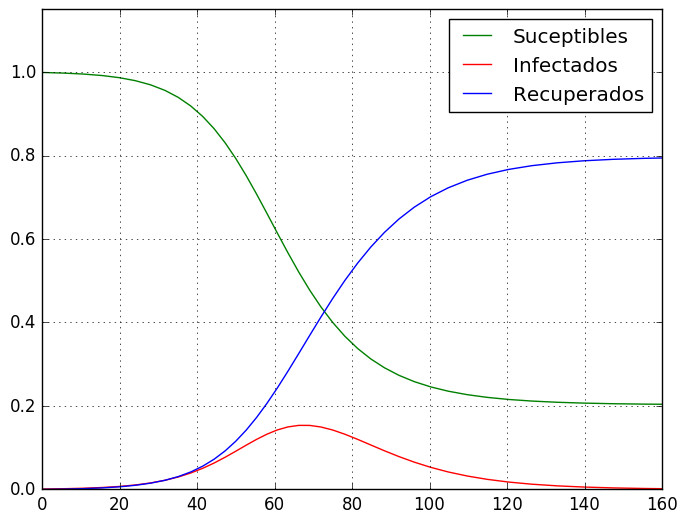

PyObject <matplotlib.legend.Legend object at 0x00000000279B0208>

In [4]:
grafica_1 = figure()
plot(t,s, color = "green", label = "Suceptibles")
plot(t,i, color = "red", label = "Infectados")
plot(t,r, color = "blue", label = "Recuperados")
axis([0,160,0,1.15])
grid()
legend()
# show()

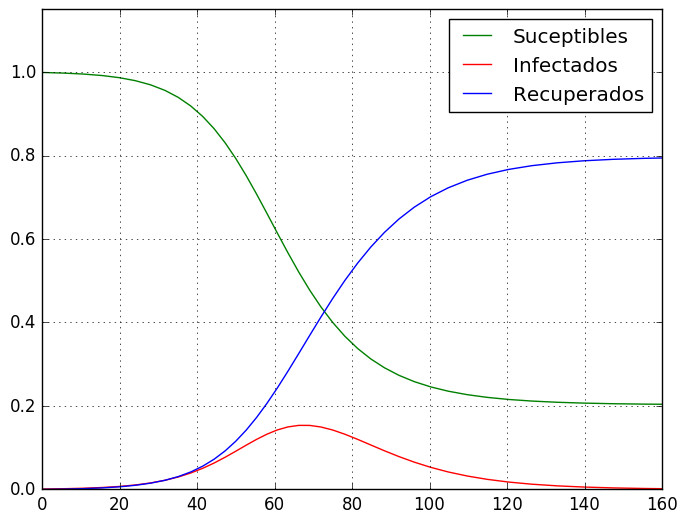

In [5]:
grafica_1

Tomamos como valores una población total $N = 1$, $N/1000$ personas infectadas y 0 recuperadas. También elegimos valores de $\beta = 0.2$ y $\gamma = 0.1$ de acuerdo con la literatura.

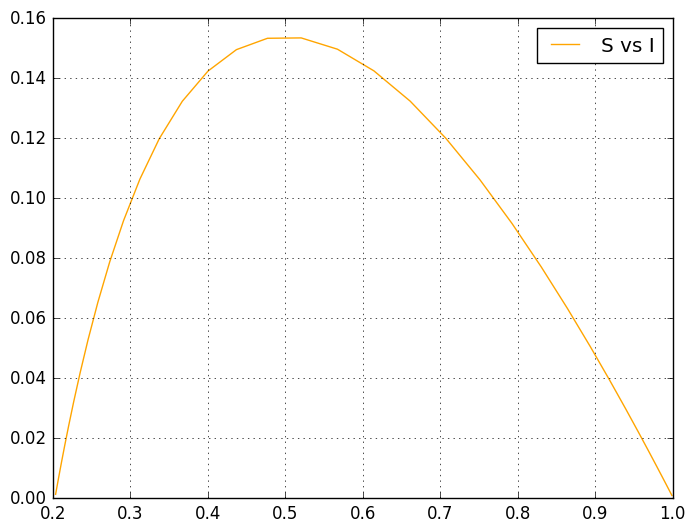

In [29]:
diagrama_fase_1 = figure()
plot(s,i, color = "orange", label = "S vs I")
legend()
grid()

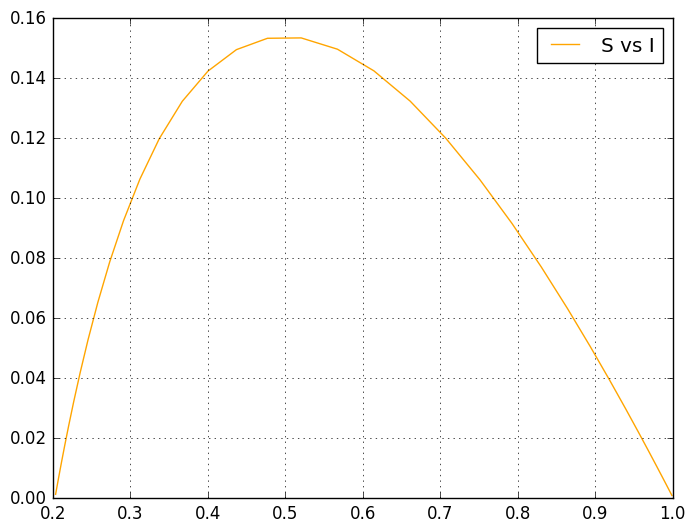

In [30]:
diagrama_fase_1

## Modelo SIRS: Inmunidad temporal o reincidencia
Ahora introducimos un término de reincidencia $\phi$, quedando las ecuaciones como:

$$ \frac{dS}{dt} = -\beta SI + \phi R$$
$$ \frac{dI}{dt} = \beta SI - \gamma I $$
$$ \frac{dR}{dt} = \gamma I -\phi R$$


In [31]:
N = 1.
t_inicial = 0.
t_final = 1400.
beta = .5
gamma = .25
phi = 0.005
infectados_iniciales = N/1000
recuperados_iniciales = 0.

@time t,s,i,r = integrador_kermack_re(N, infectados_iniciales, recuperados_iniciales, t_inicial, t_final, gamma, beta, phi);
length(t)

  2.320503 seconds (72.50 M allocations: 1.167 GB, 3.75% gc time)


204

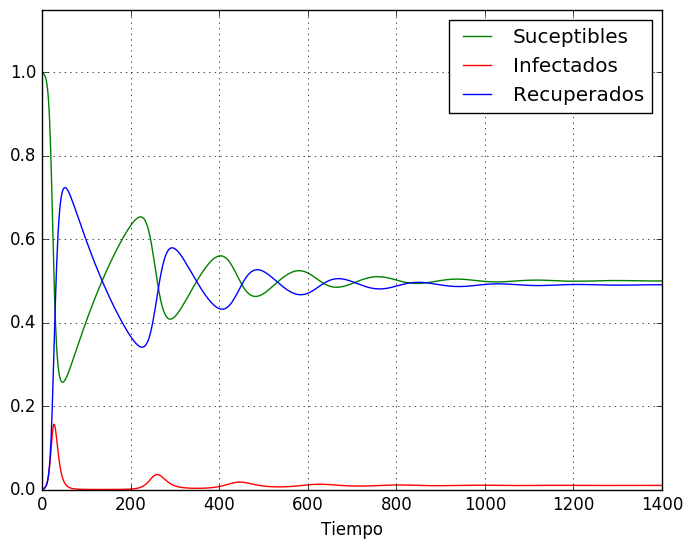

In [32]:
grafica_2 = figure()
plot(t,s, color = "green", label = "Suceptibles")
plot(t,i, color = "red", label = "Infectados")
plot(t,r, color = "blue", label = "Recuperados")
axis([0,t_final,0,1.15])
grid()
legend()
xlabel("Tiempo")
;

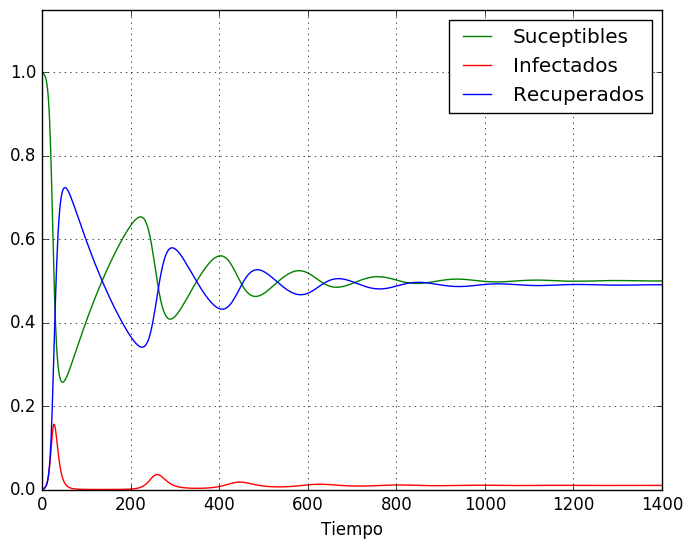

In [33]:
grafica_2

Tomamos como parámetros $\beta = 0.5$, $\gamma = 0.25$ y $\phi  = 0.005$.

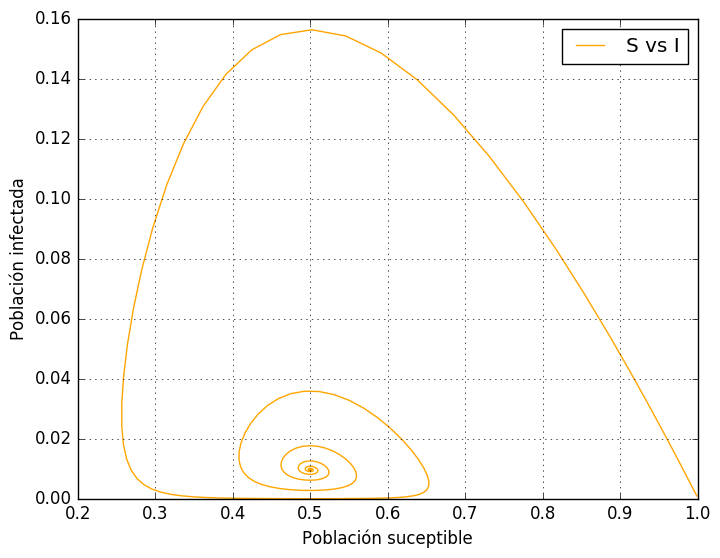

In [35]:
diagrama_fase_2 = figure()
plot(s,i, color = "orange", label = "S vs I")
legend()
xlabel("Población suceptible")
ylabel("Población infectada")
grid()

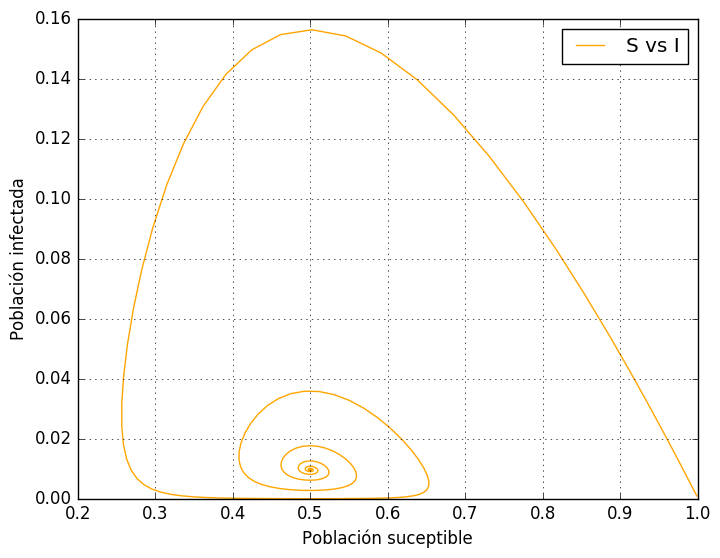

In [36]:
diagrama_fase_2

## Model SIRS con Nacimientos y Muertes
Ahora consideraremos que hay una taza de natalidad $\mu$, la cual asumiremos que es igual a la taza de mortalidad (para mantener la población constante). Con esto, el modelo queda de la siguiemte manera:

\begin{array}{rcl} 
\frac{dS}{dt}  & = & - \frac{\beta S I}{N} + \mu (N - S) + \phi R  \\ 
\frac{dI}{dt} & = & \frac{\beta S I}{N} - \gamma I - \mu I  \\
\frac{dR}{dt} & = & \gamma I - \mu R - \phi R \\
\end{array}



In [89]:
N = 1.
I0 = N/1000
R0 = 0.
S0 = N-I0-R0
ti = 0.
tf = 700.
beta = 0.2
gamma = 0.075
mu = 0.005
f = 0.00135

@time t,s,i,r = integrador_kermack_SIRS_muerte(N, I0, R0, ti, tf, gamma, beta ,mu,f);

  1.845033 seconds (62.38 M allocations: 1.010 GB, 4.77% gc time)


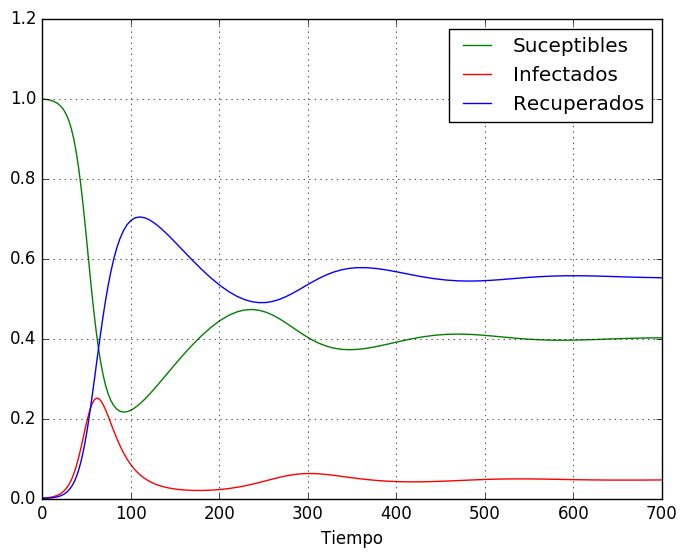

In [90]:
grafica_3 = figure()
plot(t,s, color = "green", label = "Suceptibles")
plot(t,i, color = "red", label = "Infectados")
plot(t,r, color = "blue", label = "Recuperados")
grid()
xlabel("Tiempo")
axis([0,tf,0,1.2])
legend()
show()

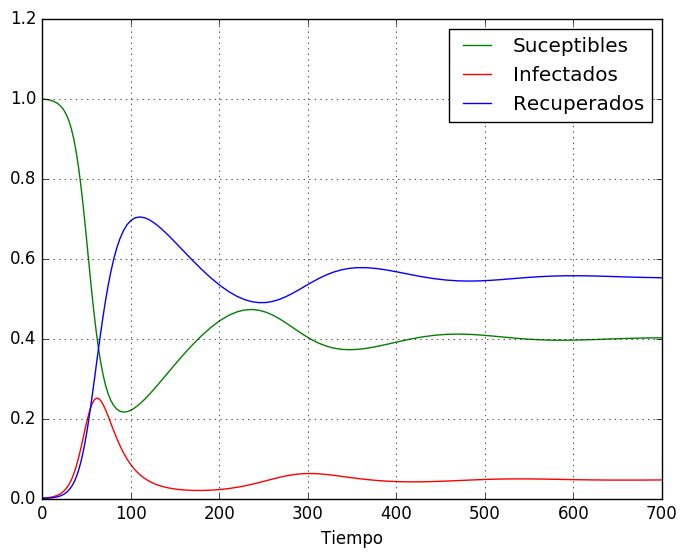

In [91]:
grafica_3

Observamos que bajo las mismas condiciones iniciales (con parámetros $\beta = 0.2$, $\gamma = 0.075$,  $\mu = 0.002$ y $\phi = 0.055$) la dinámica llega a un punto estable.

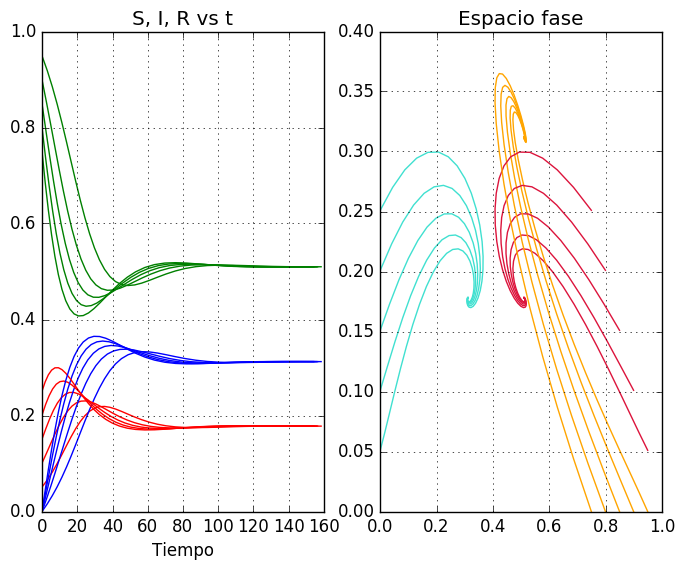

In [49]:
grafica_4 = figure()
for j in 1:5
    
    N = 1.
    I0 = N/1000+0.05*j
    R0 = 0.
    S0 = N-I0-R0
    ti = 0.
    tf = 150.
    beta = 0.2
    gamma = 0.1
    mu = 0.002
    f = 0.055


    @time t,s,i,r = integrador_kermack_SIRS_muerte(N, I0, R0, ti, tf, gamma, beta, mu, f);

    subplot(1,2,1)
    plot(t,s, color = "green", label = "Suceptibles")
    plot(t,i, color = "red", label = "Infectados")
    plot(t,r, color = "blue", label = "Recuperados")
    grid()
    
    title("S, I, R vs t")
    xlabel("Tiempo")
    
    subplot(1,2,2)
    plot(s,i, color="crimson")
    plot(s,r,color="orange")
    plot(r,i,color="turquoise")
    grid()
    
    
    title("Espacio fase")
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
end

Veamos qué pasa variando un poco nuestras condiciones iniciales. (misma guía de colores)

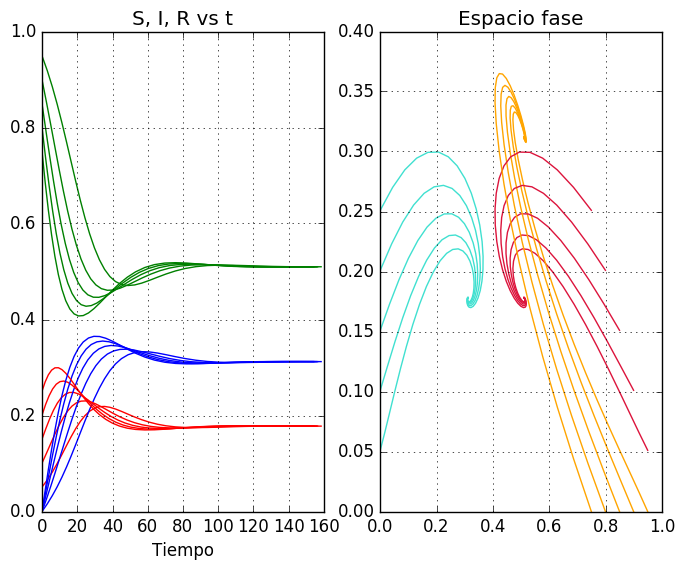

In [50]:
grafica_4

# Modelo SIR para varias especies

Para un sistema de $K$ especies, el modelo se vuelve

$$ \frac{dS_i}{dt} = -\sum_{j = 1}^K \beta_{ij} S_iI_j$$
$$ \frac{dI_i}{dt} = \sum_{j = 1}^K\beta_{ij} S_iI_j - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i $$
donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.

En este proyecto, trabajamos con 3 especies diferentes: cada una puede infectar y ser infectada por las demás; así como recuperarse con tasas distintas.

In [7]:
N1 = .5
N2 = .3
N3 = .2
I0_1 = N1/1000
I0_2 = N2/1000
I0_3 = N3/1000
R0_1 = 0.
R0_2 = 0.
R0_3 = 0.
tiempo_inicial = 0.
tiempo_final = 250.
beta = rand(3,3)/3
gamma = rand(3)/10
;

In [9]:
@time t3, s3, i3, r3 = k_3(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, gamma, beta);

  1.967435 seconds (69.20 M allocations: 1.102 GB, 3.97% gc time)


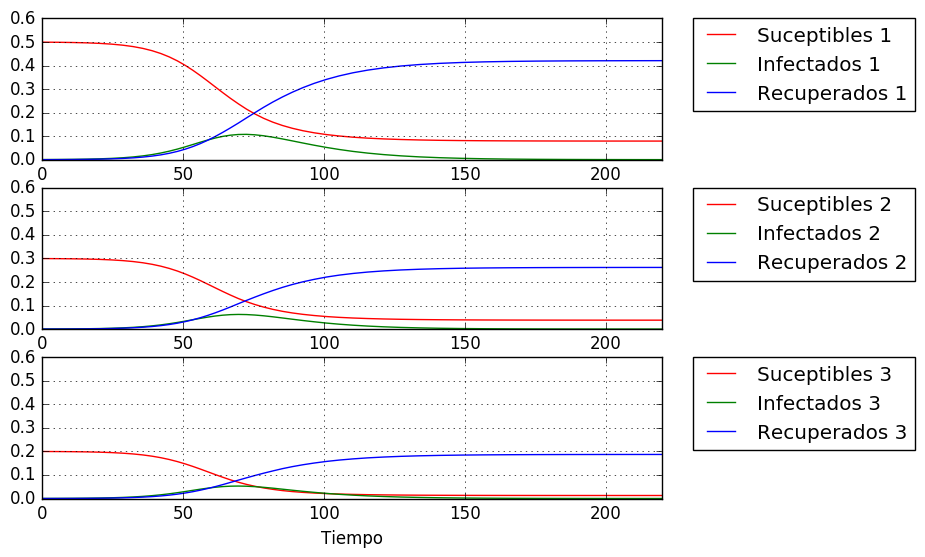

In [10]:
grafica_5 = figure()
for k = 1:3
    subplot(3,1,k)
    plot(t3, s3[k], color = "red", label = "Suceptibles $k")
    plot(t3, i3[k], color = "green", label = "Infectados $k")
    plot(t3, r3[k], color = "blue", label = "Recuperados $k")
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axis([0, 220, 0, 0.6])
    grid()
end
xlabel("Tiempo")
show()

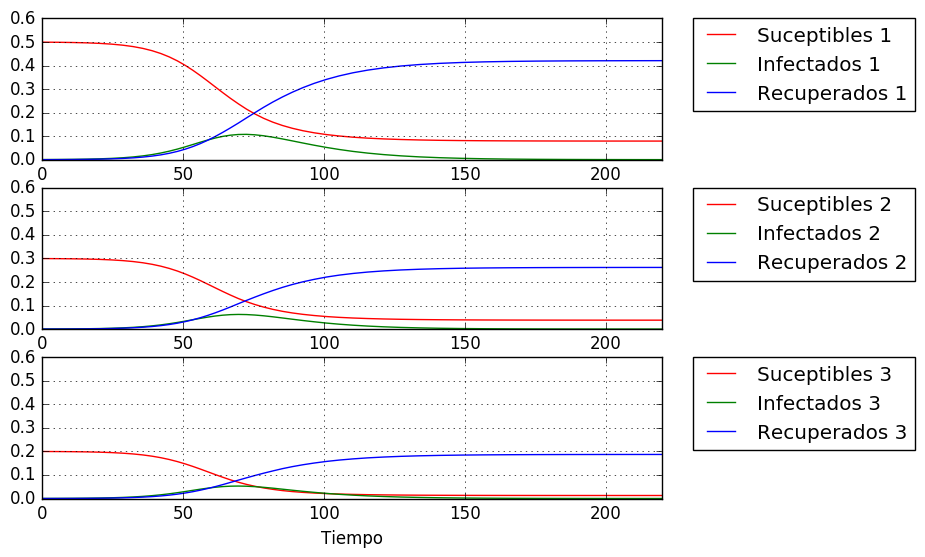

In [11]:
grafica_5

Tomando $N1 = 0.5, N2 = 0.3, N3 = 0.2$ (de manera que $N = N1+N2+N3=1$), $N_k/1000$ infectados para cada población y 0 recuperados iniciales.
Como ahora $\beta$ y $\gamma$ son matrices, creamos una matriz aleatoria que estuviera acorde a los valores en la literatura.

# Modelo SIRS: Reincidencia en 3 especies

Si ahora complicamos un poco más las cosas, podemos introducir de nuevo el parámetro $\phi$ de reincidencia en el modelo para múltiples especies. Así - y con 3 poblaciones - queda:
$$ \frac{dS_i}{dt} = -\beta_{i1} S_iI_1 - \beta_{i2} S_iI_2 - \beta_{i3} S_iI_3 + \phi_i R_i$$
$$ \frac{dI_i}{dt} = \beta_{i1} S_iI_1 + \beta_{i2} S_iI_2 + \beta_{i3} S_iI_3 - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i - \phi_i R_i$$

In [6]:
N1 = 1.
N2 = 0.66
N3 = 0.33
I0_1 = N1/1000
I0_2 = N2/1000
I0_3 = N3/1000
R0_1 = 0.
R0_2 = 0.
R0_3 = 0.
tiempo_inicial = 0.
tiempo_final = 750.

Beta = [0.134526   0.0449375  0.283664; 0.0322725  0.319525   0.253701; 0.282935   0.239162   0.113143]
Gamma = [0.0465392; 0.0549394; 0.0497149]
Phi = [0.00212581; 0.00188398; 0.00152644]
;

In [68]:
@time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, 
tiempo_final, Gamma, Beta, Phi);

  4.670012 seconds (158.61 M allocations: 2.564 GB, 4.24% gc time)


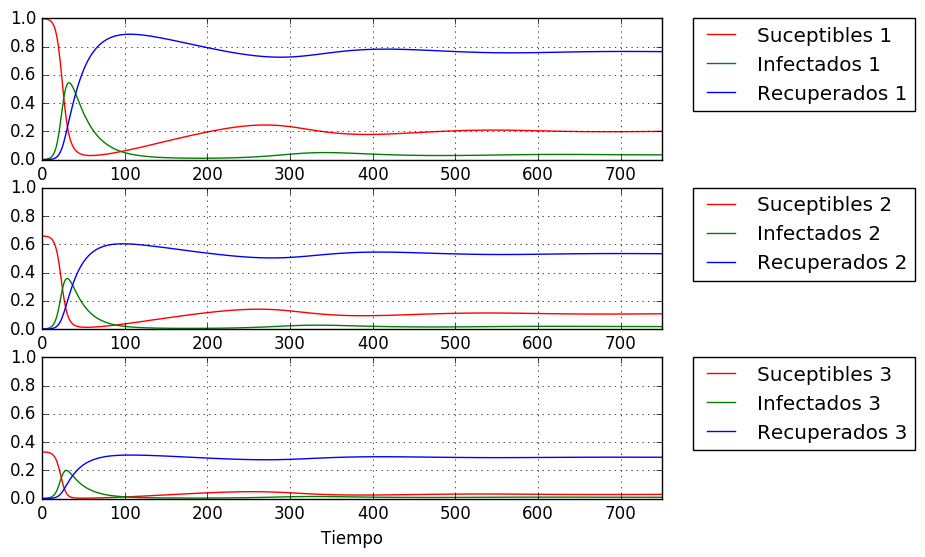

In [69]:
grafica_6 = figure()
for k = 1:3
    subplot(3,1,k)
    plot(t3, s3[k], color = "red", label = "Suceptibles $k")
    plot(t3, i3[k], color = "green", label = "Infectados $k")
    plot(t3, r3[k], color = "blue", label = "Recuperados $k")
    axis([0,tiempo_final, 0, 1])
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    grid()
end
xlabel("Tiempo")
show()

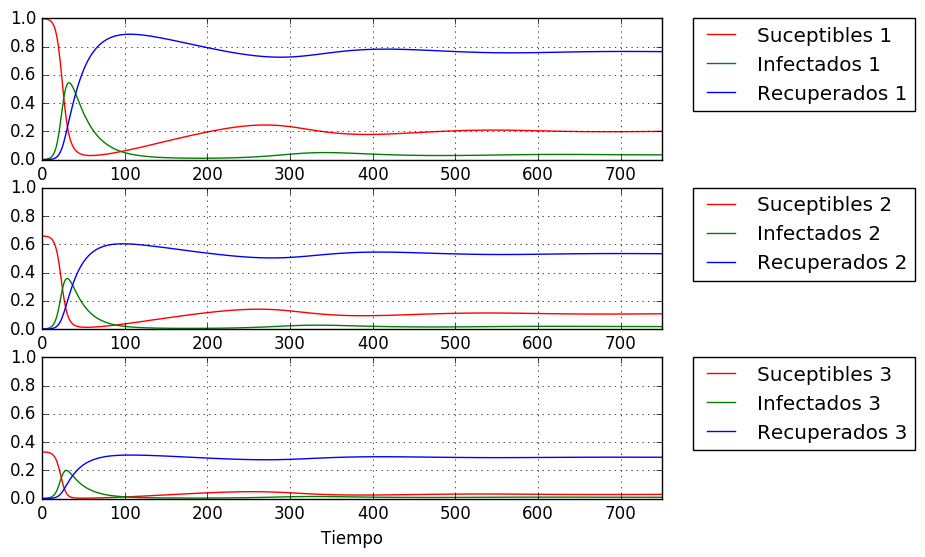

In [75]:
grafica_6

$N1 = 1, N2 = 0.66, N3 = 0.33$, cada población empezó con $N_k/1000$ infectados y 0 recuperados. Se tomaron valores particulares de $\beta_{ij}, \gamma_{i}, \phi_{i}$.

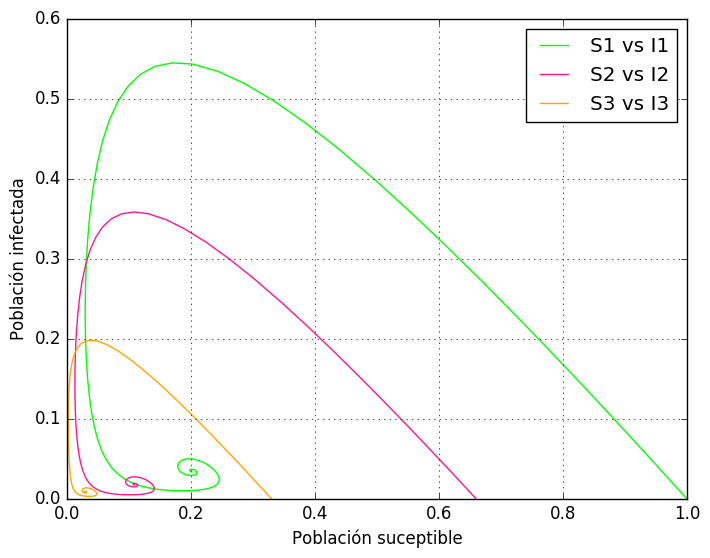

In [73]:
diagrama_fase_3 = figure()
plot(s3[1],i3[1], color = "lime", label = "S1 vs I1")
plot(s3[2],i3[2], color = "deeppink", label = "S2 vs I2")
plot(s3[3],i3[3], color = "orange", label = "S3 vs I3")
legend()
grid()
xlabel("Población suceptible")
ylabel("Población infectada")
show()

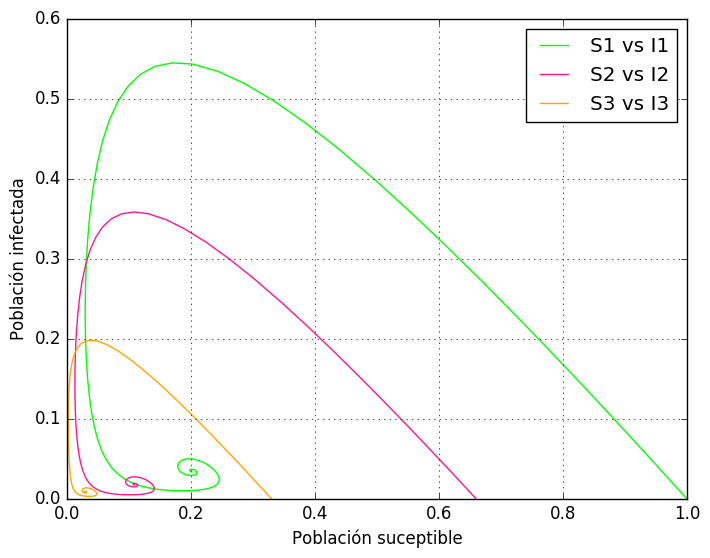

In [74]:
diagrama_fase_3

Ahora queremos empezar a ver la dinámica si perturbamos las condiciones iniciales. Como ejemplo ilustrativo, lo haremos sobre la población 1 de nuestro problema anterior.

  6.980221 seconds (157.10 M allocations: 2.540 GB, 2.94% gc time)
  6.822803 seconds (155.59 M allocations: 2.515 GB, 2.86% gc time)
  6.719039 seconds (154.08 M allocations: 2.491 GB, 2.85% gc time)
  6.653496 seconds (152.57 M allocations: 2.466 GB, 2.89% gc time)
  6.639202 seconds (151.06 M allocations: 2.442 GB, 2.88% gc time)
  6.556082 seconds (151.06 M allocations: 2.442 GB, 2.90% gc time)
  6.422911 seconds (149.55 M allocations: 2.417 GB, 2.93% gc time)
  6.470260 seconds (149.55 M allocations: 2.417 GB, 2.92% gc time)
  6.463308 seconds (148.04 M allocations: 2.393 GB, 2.90% gc time)
  6.483879 seconds (148.04 M allocations: 2.393 GB, 2.91% gc time)
  6.448228 seconds (146.53 M allocations: 2.369 GB, 2.92% gc time)
  6.456907 seconds (146.53 M allocations: 2.369 GB, 2.91% gc time)
  6.403229 seconds (146.53 M allocations: 2.369 GB, 2.91% gc time)
  6.400938 seconds (145.02 M allocations: 2.344 GB, 2.90% gc time)
  6.360918 seconds (145.02 M allocations: 2.344 GB, 2.93% gc t

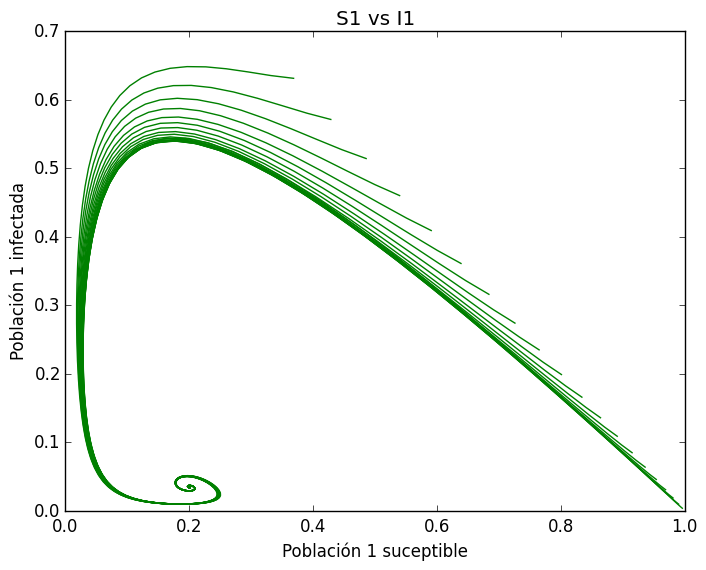

 6.272885 seconds (142.00 M allocations: 2.295 GB, 2.93% gc time)


In [20]:
diagrama_fase_4 = figure()
for i in 1:20
    I0_1 += 0.003*i
    @time t3, s3, i3 = k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, 
    Gamma, Beta, Phi);    
    plot(s3[1],i3[1], color = "green")
    grid()
end
title("S1 vs I1")
xlabel("Población 1 suceptible")
ylabel("Población 1 infectada")
show()

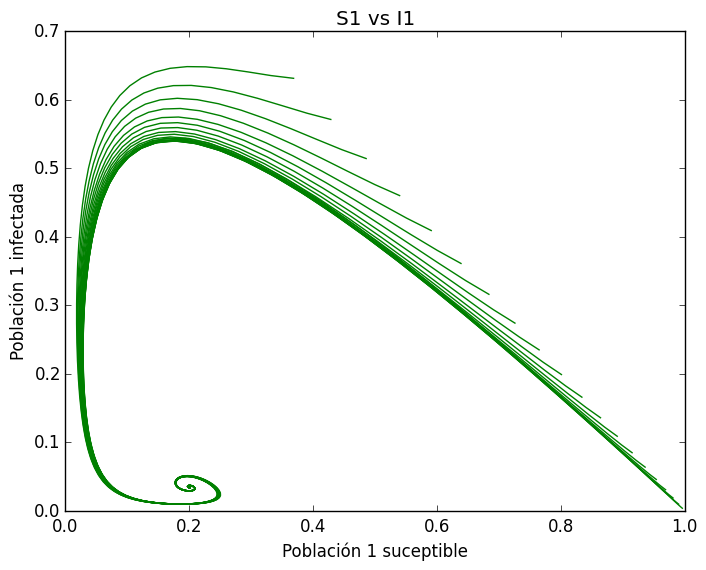

In [21]:
diagrama_fase_4

In [7]:
gamma_crit = [0.0382117, 0.0378735, 0.0425732]
beta_crit = [0.159791 0.143463 0.136713;0.330302 0.152469 0.304485;0.160856 0.30528 0.0269721]
phi_crit = [0.00614901,0.00135588,0.00385677]

function soluciones!(x, svec)
    svec[1] = 0
    svec[2] = 0
    svec[3] = 0
    ### Para S1, S2, S3
    for j = 1:3
        for k = 1:3
            svec[j] += -beta_crit[j,k]*x[j]*x[k+3]
        end
        svec[j] += phi_crit[j]*x[j+6]
    end
    ### Para R1, R2, R3
    for j = 1:3
        svec[j+6] = gamma_crit[j]*x[j+3]-phi_crit[j]*x[j+6]
    end
    ### Para I1, I2, I3
    svec[4] = N1-x[1]-x[4]-x[7]
    svec[5] = N2-x[2]-x[5]-x[8]
    svec[6] = N3-x[3]-x[6]-x[9]
end

soluciones! (generic function with 1 method)

In [8]:
x_inicial = 0.01*ones(9)
resultados = nlsolve(soluciones!,x_inicial);

In [9]:
S_estable_1 = resultados.zero[1]
S_estable_2 = resultados.zero[2]
S_estable_3 = resultados.zero[3]
I_estable_1 = resultados.zero[4]
I_estable_2 = resultados.zero[5]
I_estable_3 = resultados.zero[6]
R_estable_1 = resultados.zero[7]
R_estable_2 = resultados.zero[8]
R_estable_3 = resultados.zero[9]
tiempo_inicial = 0.
tiempo_final = 500.
;

In [11]:
t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I_estable_1, I_estable_2, 
I_estable_3, R_estable_1, R_estable_2, R_estable_3,tiempo_inicial, tiempo_final, 
gamma_crit, beta_crit, phi_crit);

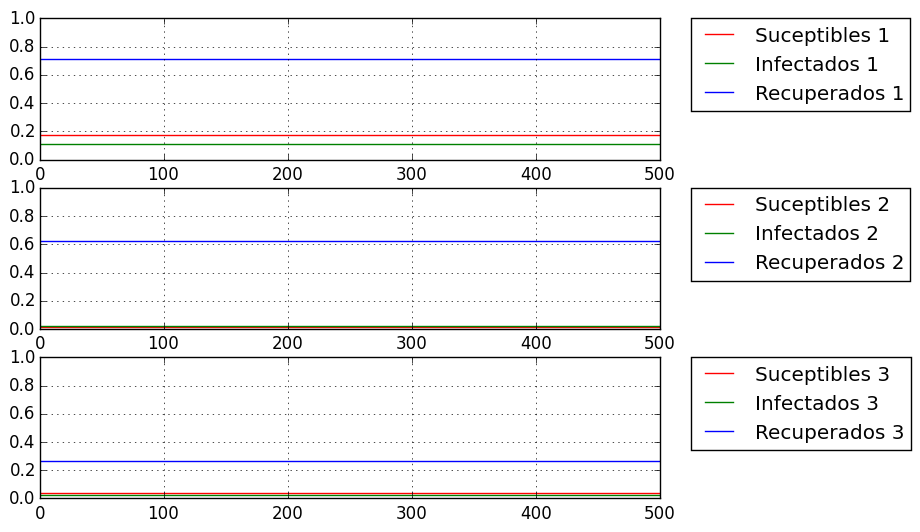

In [13]:
gráfica_6 = figure()
for k = 1:3
    subplot(3,1,k)
    plot(t3, s3[k], color = "red", label = "Suceptibles $k")
    plot(t3, i3[k], color = "green", label = "Infectados $k")
    plot(t3, r3[k], color = "blue", label = "Recuperados $k")
    axis([0,tiempo_final, 0, 1])
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    grid()
end

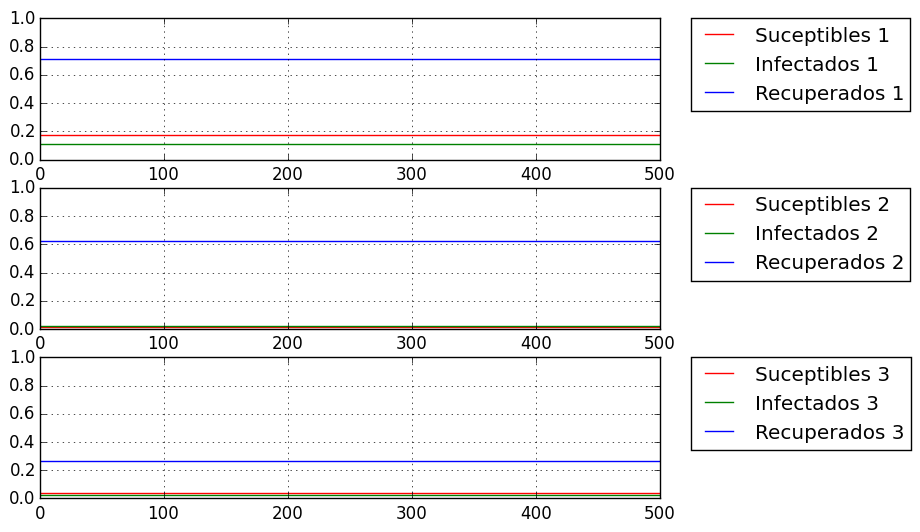

In [14]:
gráfica_6

Ahora que tenemos el quilibrio endémico vamos a perturbarlo de distintas maneras y ver qué se obtiene.

  0.788919 seconds (18.13 M allocations: 300.053 MB, 3.07% gc time)
  1.295201 seconds (31.72 M allocations: 525.093 MB, 3.02% gc time)
  1.358516 seconds (33.23 M allocations: 550.097 MB, 2.98% gc time)
  1.562969 seconds (36.25 M allocations: 600.106 MB, 2.93% gc time)
  1.615612 seconds (37.76 M allocations: 625.110 MB, 3.02% gc time)
  1.631935 seconds (39.28 M allocations: 650.114 MB, 2.95% gc time)
  1.721760 seconds (40.79 M allocations: 675.118 MB, 3.03% gc time)
  1.793307 seconds (42.30 M allocations: 700.122 MB, 3.03% gc time)
 

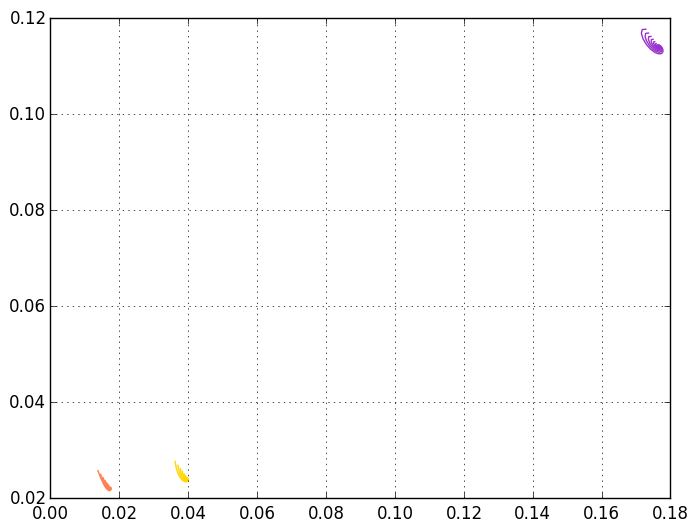

 1.837547 seconds (43.81 M allocations: 725.126 MB, 3.01% gc time)


In [41]:
eps_abs = 1e-39

I_perturbado_1 = I_estable_1
I_perturbado_2 = I_estable_2
I_perturbado_3 = I_estable_3
tiempo_inicial = 0.
tiempo_final = 500.

fase_5 = figure()
for i in 0:8
    I_perturbado_1 += 0.0001*i
    I_perturbado_2 += 0.0001*i
    I_perturbado_3 += 0.0001*i
    
    @time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I_perturbado_1, I_perturbado_2, 
    I_perturbado_3, R_estable_1, R_estable_2, R_estable_3,tiempo_inicial, tiempo_final, 
    gamma_crit, beta_crit, phi_crit);  
    
    colores = ["darkorchid", "coral", "gold"]
    
    for k in 1:3
#     k = 1
        plot(s3[k],i3[k], color = colores[k])
    end
end
grid()
show()

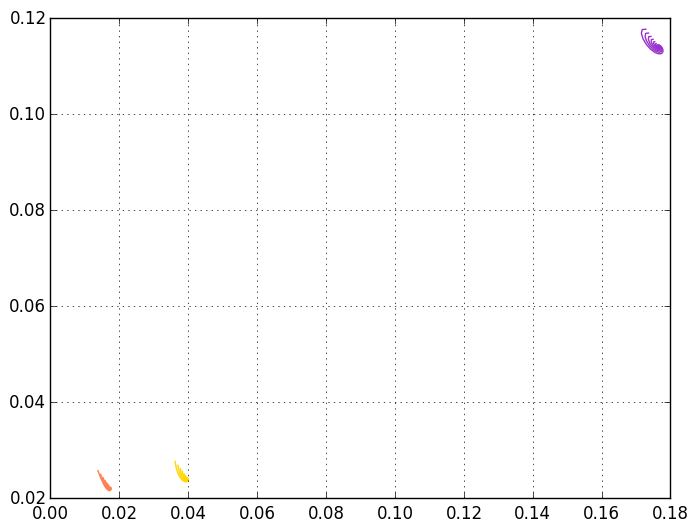

In [16]:
fase_5

Diagramas fase de $I_k$ vs $S_k$ con $k=1,2,3$, perturbando $I$, $I_2$ e $I_3$.

  1.295820 seconds (33.23 M allocations: 550.097 MB, 2.87% gc time)
  1.395275 seconds (36.25 M allocations: 600.106 MB, 2.94% gc time)
  1.522428 seconds (39.28 M allocations: 650.114 MB, 2.77% gc time)
  1.640642 seconds (42.30 M allocations: 700.122 MB, 2.76% gc time)
  1.687087 seconds (43.81 M allocations: 725.126 MB, 2.74% gc time)
  1.802451 seconds (46.83 M allocations: 775.134 MB, 2.79% gc time)
  1.856191 seconds (48.34 M allocations: 800.144 MB, 2.73% gc time)
  1.924706 seconds (49.85 M allocations: 825.148 MB, 2.79% gc time)
  2.040374 seconds (52.87 M allocations: 875.156 MB, 2.77% gc time)
  2.085443 seconds (54.38 M allocations: 900.160 MB, 2.77% gc time)
  2.167472 seconds (55.89 M allocations: 925.164 MB, 2.81% gc time)
  2.223719 seconds (57.40 M allocations: 950.168 MB, 2.76% gc time)
  2.280048 seconds (58.91 M allocations: 975.172 MB, 2.81% gc time)
  2.321310 seconds (60.42 M allocations: 1000.176 MB, 2.74% gc time)
  2.380706 seconds (61.93 M allocations: 1.001 

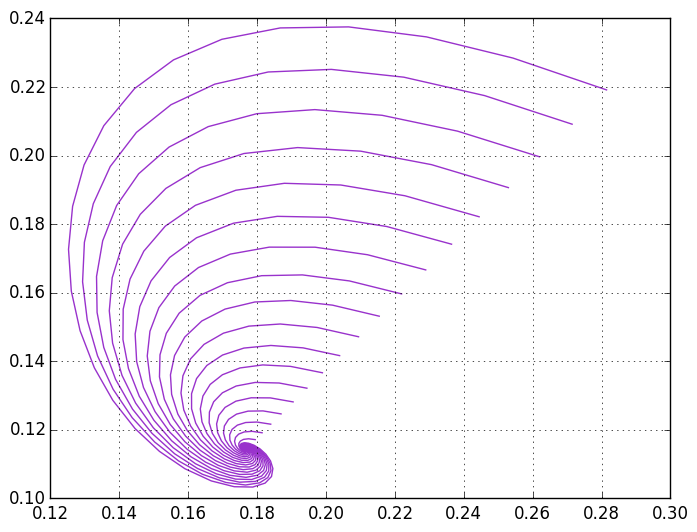

  2.687880 seconds (69.49 M allocations: 1.123 GB, 2.85% gc time)


In [12]:
eps_abs = 1e-39

I_perturbado_1 = I_estable_1
I_perturbado_2 = I_estable_2
I_perturbado_3 = I_estable_3

R_perturbado_1 = R_estable_1
R_perturbado_2 = R_estable_2
R_perturbado_3 = R_estable_3

fase_6 = figure()
for i in 1:20
    I_perturbado_1 += 0.0005*i
#     I_perturbado_2 += 0.005*i
#     I_perturbado_3 += 0.001*i
    
    R_perturbado_1 += -0.001*i
#     R_perturbado_2 += -0.005*i
#     R_perturbado_3 += -0.003*i
    

    @time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I_perturbado_1, I_perturbado_2, 
    I_perturbado_3, R_perturbado_1, R_perturbado_2, R_perturbado_3,tiempo_inicial, tiempo_final, 
    gamma_crit,beta_crit,phi_crit);  
    colores = ["darkorchid", "coral", "gold"]
    for k = 1:1
#         subplot(3,1,k)
        plot(s3[k],i3[k], color = colores[k])
    end
end
grid()
show()

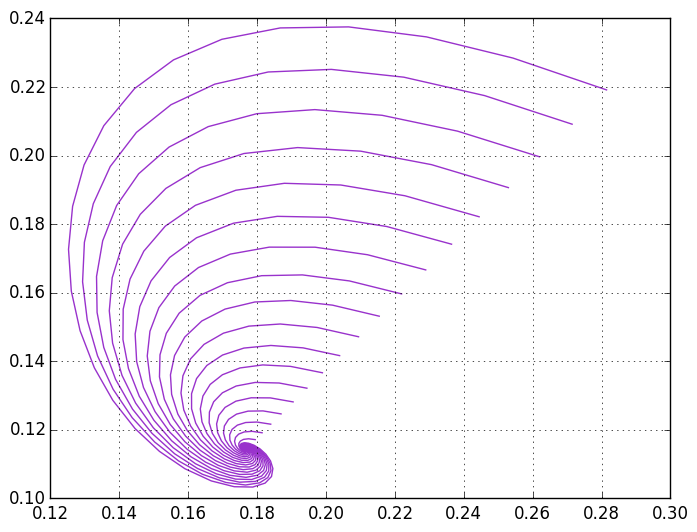

In [47]:
fase_6

In [16]:
I_pert_1 = resultados.zero[4]
I_pert_2 = resultados.zero[5]
I_pert_3 = resultados.zero[6]
R_pert_1 = resultados.zero[7] 
R_pert_2 = resultados.zero[8] 
R_pert_3 = resultados.zero[9]
tiempo_inicial = 0.
tiempo_final = 2500.
;

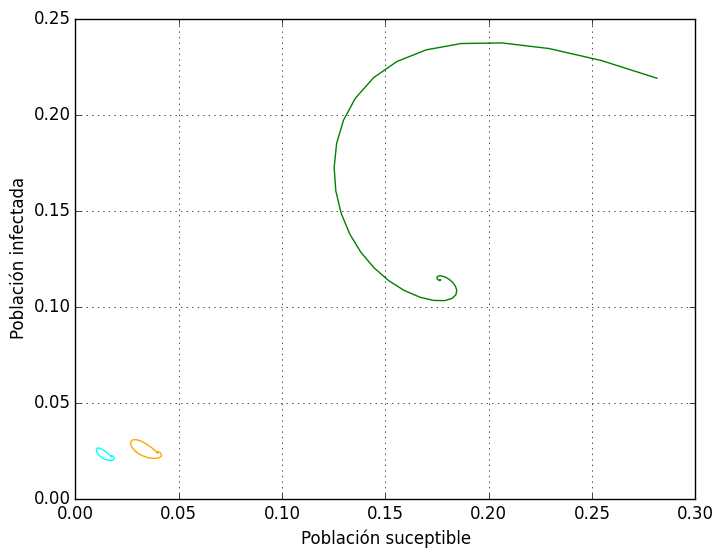

In [13]:
fase_13 = figure()
plot(s3[1],i3[1], color = "green", label = "S1 vs I1")
#plot(s3[1],i3[2], color = "red", label = "S1 vs I2")
#plot(s3[1],i3[3], color = "blue", label = "S1 vs I3")
plot(s3[2],i3[2], color = "cyan", label = "S2 vs I2")
#plot(s3[2],i3[3], color = "magenta", label = "S2 vs I3")
plot(s3[3],i3[3], color = "orange", label = "S3 vs I3")
#plot(r3[1],i3[1], color = "peru", label = "R3 vs I3")
#legend()
grid()
xlabel("Población suceptible")
ylabel("Población infectada")
show()

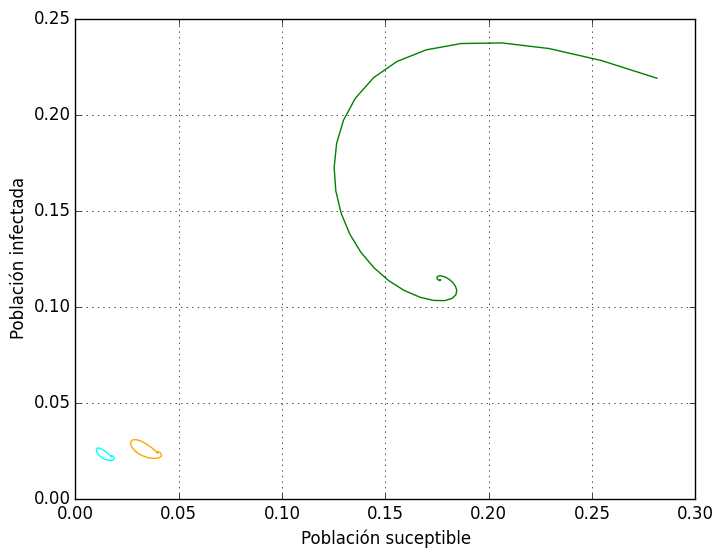

In [31]:
fase_13

Diagramas fase de $I_k$ vs $S_k$ con $k=1,2,3$, perturbando $I_1$ y $R_1$.

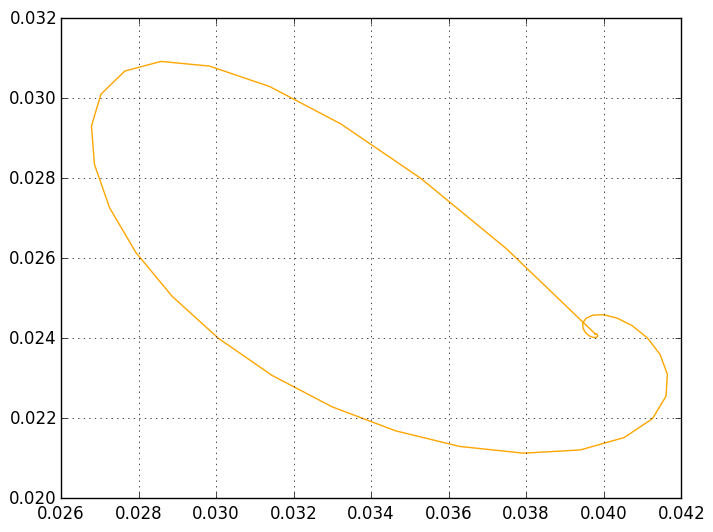

In [37]:
plot(s3[3],i3[3], color = "orange", label = "S3 vs I3")
grid()

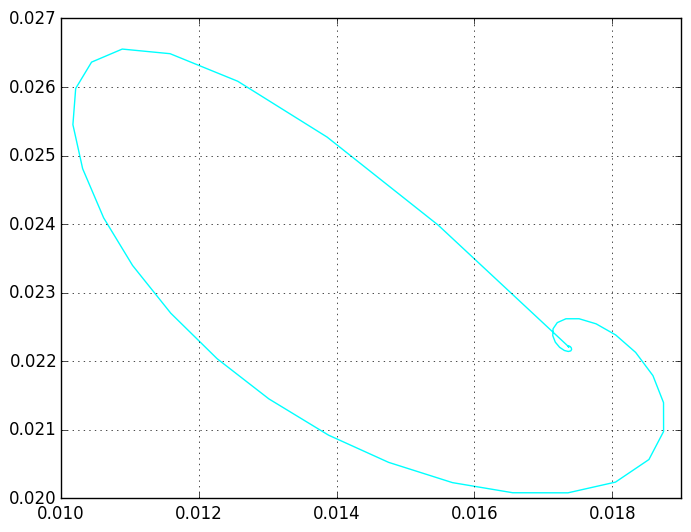

In [39]:
plot(s3[2],i3[2], color = "cyan", label = "S3 vs I3")
grid()

  9.318523 seconds (241.70 M allocations: 3.907 GB, 2.95% gc time)
  9.485544 seconds (247.74 M allocations: 4.005 GB, 2.91% gc time)
 10.133816 seconds (262.84 M allocations: 4.249 GB, 2.94% gc time)
 13.345059 seconds (342.91 M allocations: 5.543 GB, 2.92% gc time)
 11.252887 seconds (291.55 M allocations: 4.713 GB, 2.92% gc time)
 10.610657 seconds (274.93 M allocations: 4.444 GB, 2.94% gc time)


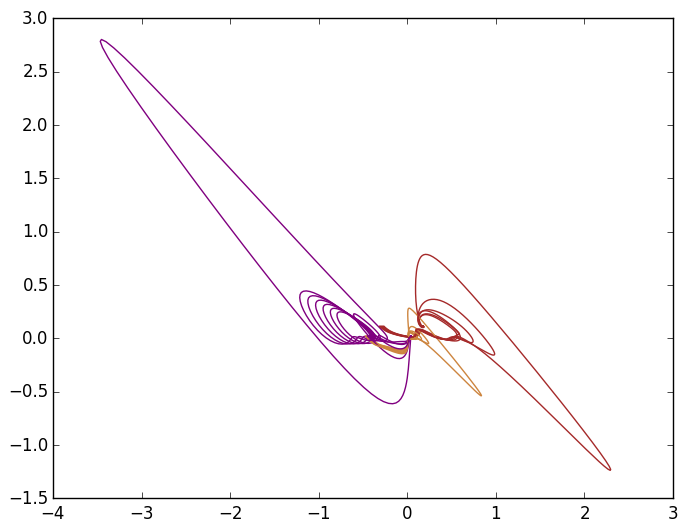

In [17]:
fase_7 = figure()
for i in 44:49
    R_pert_1 = resultados.zero[7] + 0.01*i
    R_pert_2 = resultados.zero[8] + 0.01*i
    R_pert_3 = resultados.zero[9] + 0.01*i
    
    @time t3_expl,s3_expl,i3_expl,r3_expl = k_3_reincidencia(N1, N2, N3, I_pert_1, I_pert_2, 
I_pert_3, R_pert_1, R_pert_2, R_pert_3,tiempo_inicial, tiempo_final, 
    gamma_crit, beta_crit, phi_crit);
    plot(s3_expl[1],i3_expl[1], color = "brown", label = "S3 vs I3")
    plot(s3_expl[2],i3_expl[2], color = "peru", label = "S3 vs I3")
    plot(s3_expl[3],i3_expl[3], color = "purple", label = "S3 vs I3")
    grid()
end

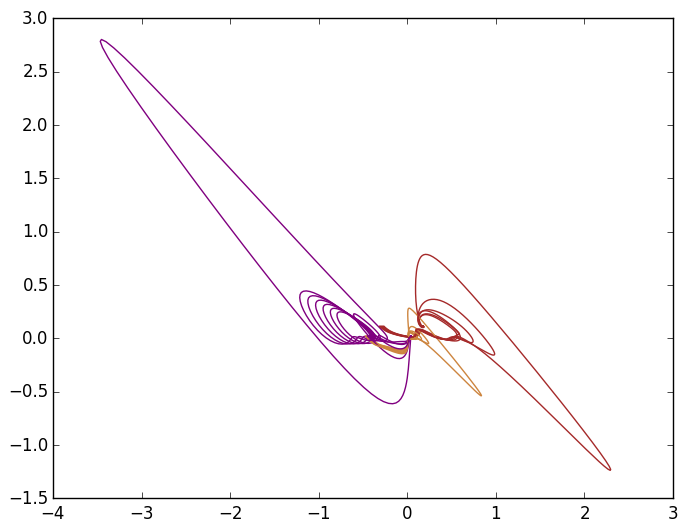

In [24]:
fase_7

Diagramas fase de $I_k$ vs $S_k$ con $k=1,2,3$, perturbando $R_1$, $R_2$ e $R_3$. Iteraciones 44 a 49.

117.078171 seconds (3.02 G allocations: 48.812 GB, 3.02% gc time)
116.807822 seconds (3.02 G allocations: 48.812 GB, 3.00% gc time)
  9.859381 seconds (252.27 M allocations: 4.078 GB, 3.02% gc time)


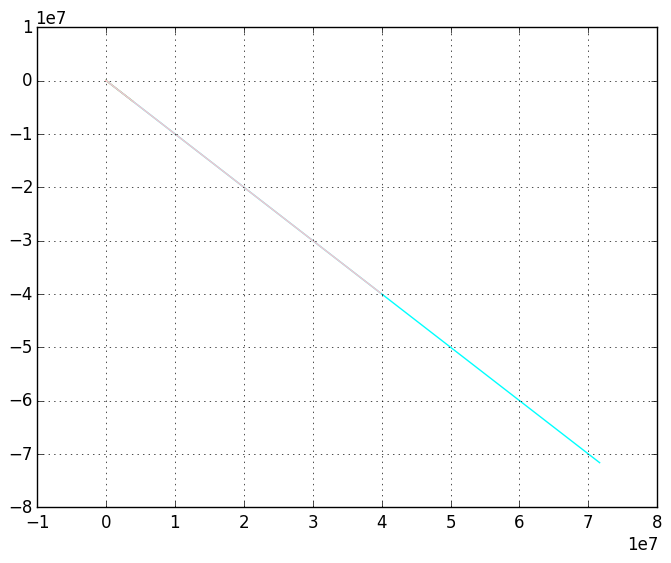

In [37]:
fase_8 = figure()
for i in 41:43
    R_pert_1 = resultados.zero[7] + 0.01*i
    R_pert_2 = resultados.zero[8] + 0.01*i
    R_pert_3 = resultados.zero[9] + 0.01*i
    
    @time t3_expl,s3_expl,i3_expl,r3_expl = k_3_reincidencia(N1, N2, N3, I_pert_1, I_pert_2, 
I_pert_3, R_pert_1, R_pert_2, R_pert_3,tiempo_inicial, tiempo_final, 
    gamma_crit, beta_crit, phi_crit);
    plot(s3_expl[1],i3_expl[1], color = "orange", label = "S3 vs I3")
    plot(s3_expl[2],i3_expl[2], color = "cyan", label = "S3 vs I3")
    plot(s3_expl[3],i3_expl[3], color = "pink", label = "S3 vs I3")
    grid()
end

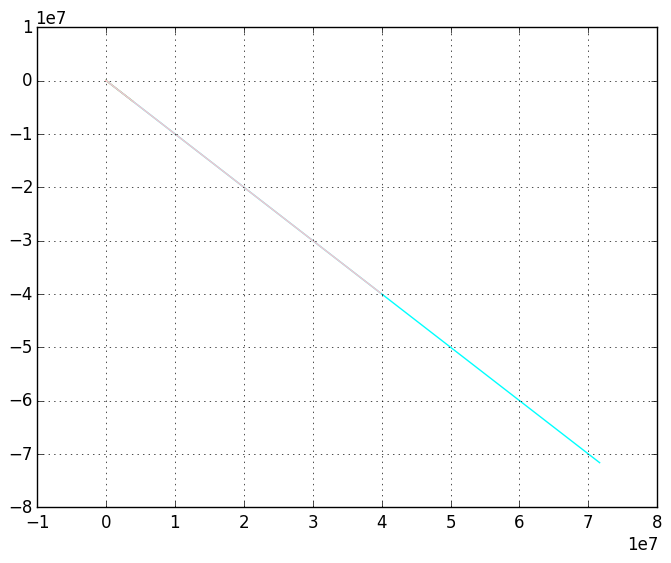

In [29]:
fase_8

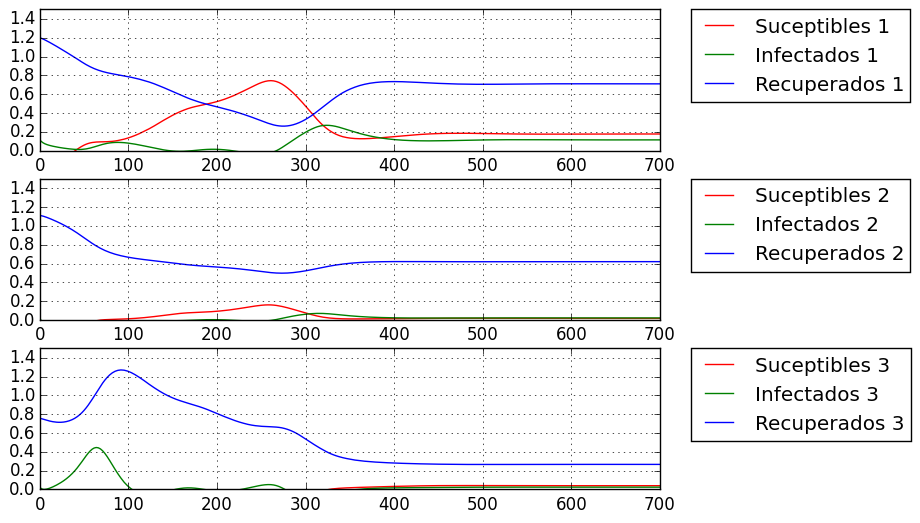

In [41]:
gráfica_11 = figure()
for k = 1:3
    subplot(3,1,k)
    plot(t3_atrac, s3_atrac[k], color = "red", label = "Suceptibles $k")
    plot(t3_atrac, i3_atrac[k], color = "green", label = "Infectados $k")
    plot(t3_atrac, r3_atrac[k], color = "blue", label = "Recuperados $k")
    axis([0,700., 0, 1.5])
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    grid()
end

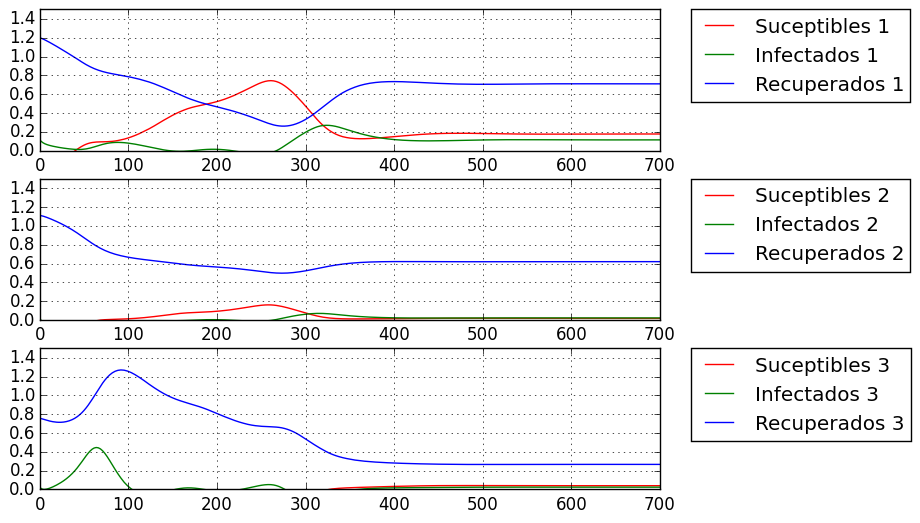

In [42]:
gráfica_11

Diagramas fase de $I_k$ vs $S_k$ con $k=1,2,3$, perturbando $R_1$, $R_2$ e $R_3$. Iteraciones 41 a 43.

116.994231 seconds (3.02 G allocations: 48.812 GB, 2.96% gc time)
  9.648689 seconds (252.27 M allocations: 4.078 GB, 2.97% gc time)
  9.290956 seconds (241.70 M allocations: 3.907 GB, 2.98% gc time)
  9.548094 seconds (247.74 M allocations: 4.005 GB, 2.97% gc time)
 10.084540 seconds (262.84 M allocations: 4.249 GB, 2.99% gc time)
 13.285709 seconds (342.91 M allocations: 5.543 GB, 2.97% gc time)
 11.170056 seconds (291.55 M allocations: 4.713 GB, 3.01% gc time)
 10.772418 seconds (274.93 M allocations: 4.444 GB, 2.97% gc time)


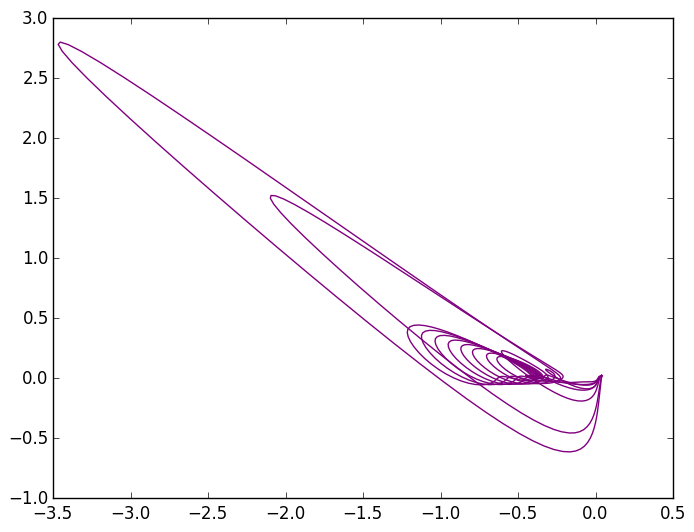

In [18]:
fase_9 = figure()
for i in 42:49
    R_pert_1 = resultados.zero[7] + 0.01*i
    R_pert_2 = resultados.zero[8] + 0.01*i
    R_pert_3 = resultados.zero[9] + 0.01*i
    
    @time t3_expl,s3_expl,i3_expl,r3_expl = k_3_reincidencia(N1, N2, N3, I_pert_1, I_pert_2, 
I_pert_3, R_pert_1, R_pert_2, R_pert_3,tiempo_inicial, tiempo_final, 
    gamma_crit, beta_crit, phi_crit);
    #plot(s3_expl[3],i3_expl[3], color = "brown", label = "S3 vs I3")
    #plot(s3_expl[2],i3_expl[2], color = "peru", label = "S3 vs I3")
    plot(s3_expl[3],i3_expl[3], color = "purple", label = "S3 vs I3")
    grid()
end

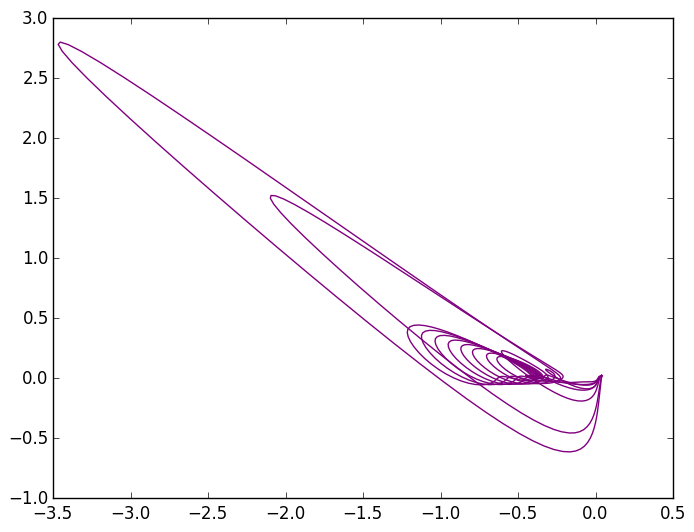

In [19]:
fase_9

In [20]:
fase_10 = figure()
for i in 1:39
    R_pert_1 = resultados.zero[7] + 0.01*i
    R_pert_2 = resultados.zero[8] + 0.01*i
    R_pert_3 = resultados.zero[9] + 0.01*i
    
    @time t3_expl,s3_expl,i3_expl,r3_expl = k_3_reincidencia(N1, N2, N3, I_pert_1, I_pert_2, 
I_pert_3, R_pert_1, R_pert_2, R_pert_3,tiempo_inicial, tiempo_final, 
    gamma_crit, beta_crit, phi_crit);
    #plot(s3_expl[3],i3_expl[3], color = "brown", label = "S3 vs I3")
    #plot(s3_expl[2],i3_expl[2], color = "peru", label = "S3 vs I3")
    plot(s3_expl[3],i3_expl[3], color = "purple", label = "S3 vs I3")
    grid()
end

  4.617993 seconds (117.83 M allocations: 1.905 GB, 3.01% gc time)
  4.974065 seconds (126.89 M allocations: 2.051 GB, 2.98% gc time)
  5.176868 seconds (132.93 M allocations: 2.149 GB, 3.03% gc time)


LoadError: LoadError: InterruptException:
while loading In[20], in expression starting on line 2

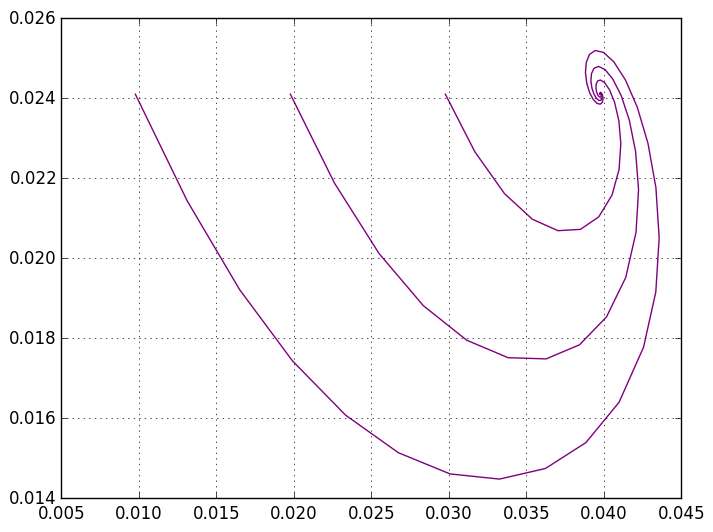

In [21]:
fase_10

116.246731 seconds (3.02 G allocations: 48.812 GB, 3.05% gc time)


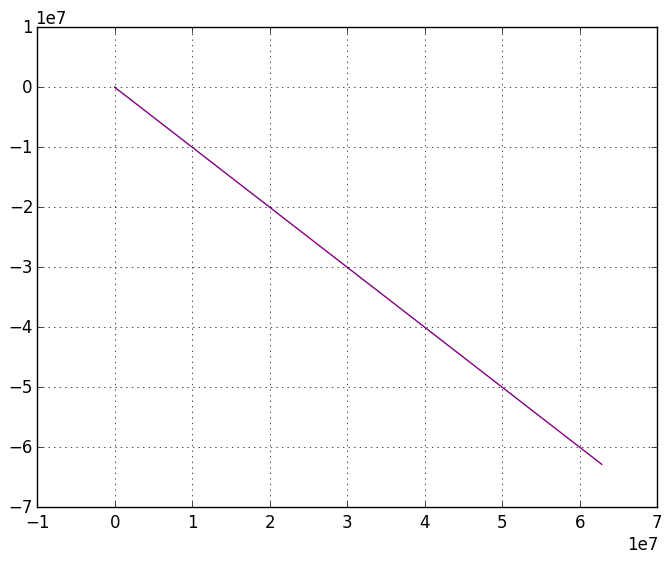

In [22]:
fase_11 = figure()
for i in 40:40
    R_pert_1 = resultados.zero[7] + 0.01*i
    R_pert_2 = resultados.zero[8] + 0.01*i
    R_pert_3 = resultados.zero[9] + 0.01*i
    
    @time t3_expl,s3_expl,i3_expl,r3_expl = k_3_reincidencia(N1, N2, N3, I_pert_1, I_pert_2, 
I_pert_3, R_pert_1, R_pert_2, R_pert_3,tiempo_inicial, tiempo_final, 
    gamma_crit, beta_crit, phi_crit);
    #plot(s3_expl[3],i3_expl[3], color = "brown", label = "S3 vs I3")
    #plot(s3_expl[2],i3_expl[2], color = "peru", label = "S3 vs I3")
    plot(s3_expl[3],i3_expl[3], color = "purple", label = "S3 vs I3")
    grid()
end

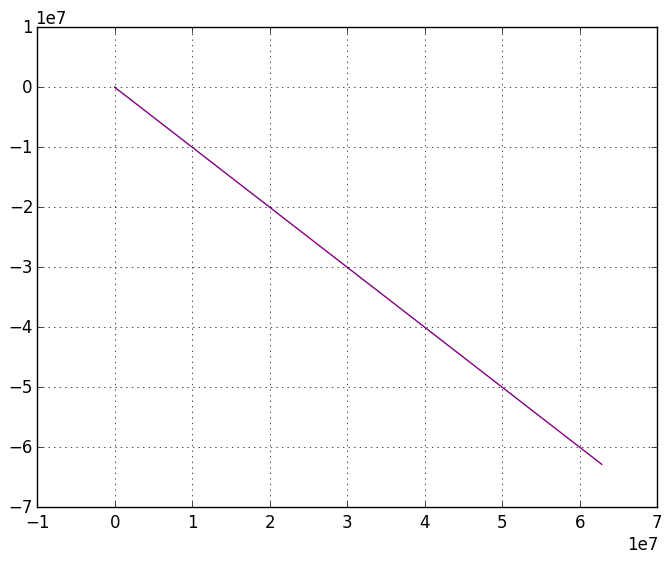

In [23]:
fase_11

El diagrama fase da valores gigantescos en la iteración 40. Esto sospechamos que realmente es un error numérico, pues se nos presentaron este tipo de errores otras veces y desaparecieron al disminuir el error absoluto de $e^{-20}$ a $e^{-39}$.

  9.725012 seconds (252.27 M allocations: 4.078 GB, 3.06% gc time)


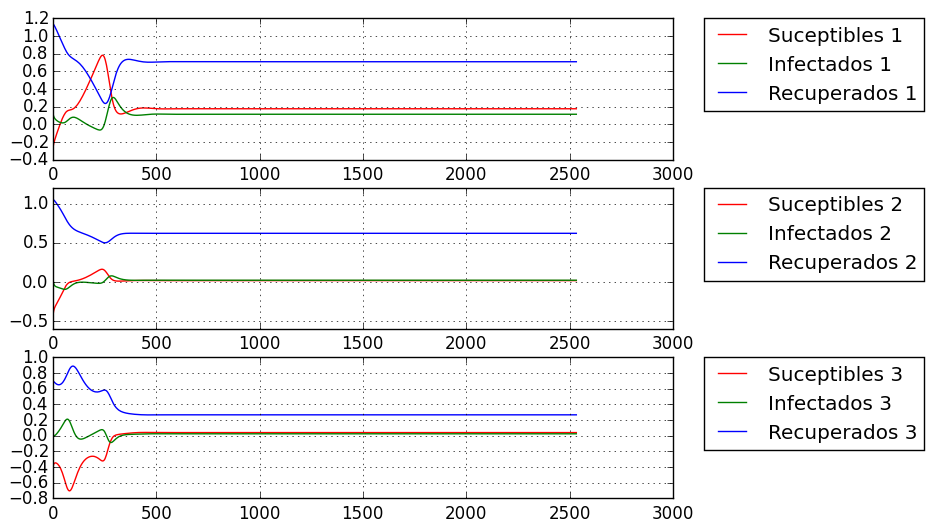

In [32]:
@time t3_expl,s3_expl,i3_expl,r3_expl = k_3_reincidencia(N1, N2, N3, I_pert_1, I_pert_2, 
I_pert_3, R_pert_1, R_pert_2, R_pert_3,tiempo_inicial, tiempo_final, 
    gamma_crit, beta_crit, phi_crit);
gráfica_8 = figure()
for k = 1:3
    subplot(3,1,k)
    plot(t3_expl, s3_expl[k], color = "red", label = "Suceptibles $k")
    plot(t3_expl, i3_expl[k], color = "green", label = "Infectados $k")
    plot(t3_expl, r3_expl[k], color = "blue", label = "Recuperados $k")
    #axis([600.,900., 0, 1.5])
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    grid()
end

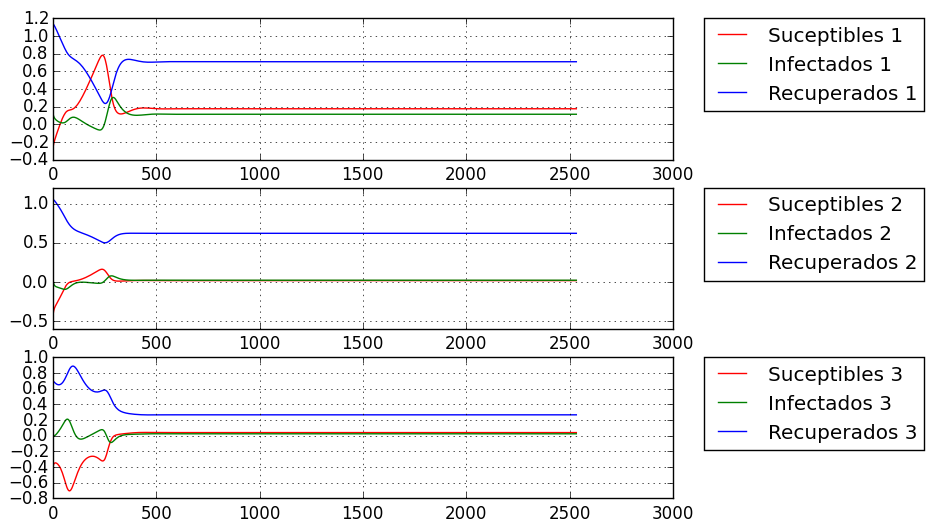

In [33]:
gráfica_8

115.331324 seconds (3.02 G allocations: 48.812 GB, 3.14% gc time)
  9.518361 seconds (252.27 M allocations: 4.078 GB, 3.14% gc time)
  9.123667 seconds (241.70 M allocations: 3.907 GB, 3.16% gc time)
  9.376703 seconds (247.74 M allocations: 4.005 GB, 3.14% gc time)
 10.143448 seconds (262.84 M allocations: 4.249 GB, 3.14% gc time)
 13.205082 seconds (342.91 M allocations: 5.543 GB, 3.16% gc time)
 11.359286 seconds (291.55 M allocations: 4.713 GB, 3.15% gc time)
 10.590048 seconds (274.93 M allocations: 4.444 GB, 3.16% gc time)


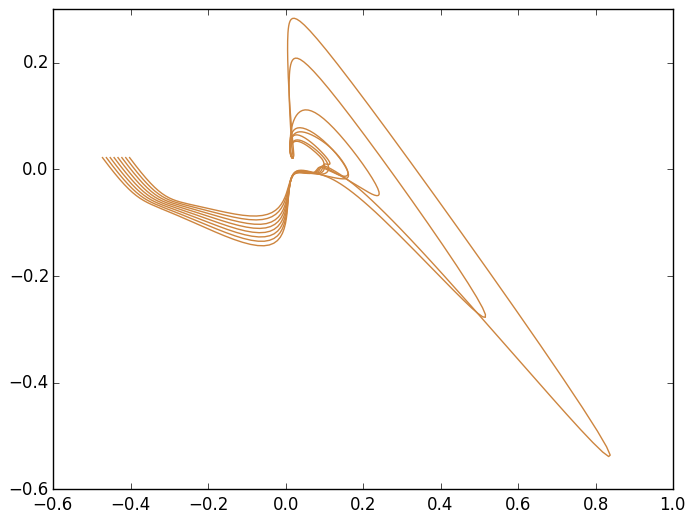

In [26]:
fase_12 = figure()
for i in 42:49
    R_pert_1 = resultados.zero[7] + 0.01*i
    R_pert_2 = resultados.zero[8] + 0.01*i
    R_pert_3 = resultados.zero[9] + 0.01*i
    
    @time t3_expl,s3_expl,i3_expl,r3_expl = k_3_reincidencia(N1, N2, N3, I_pert_1, I_pert_2, 
I_pert_3, R_pert_1, R_pert_2, R_pert_3,tiempo_inicial, tiempo_final, 
    gamma_crit, beta_crit, phi_crit);
    #plot(s3_expl[3],i3_expl[3], color = "brown", label = "S3 vs I3")
    plot(s3_expl[2],i3_expl[2], color = "peru", label = "S3 vs I3")
    #plot(s3_expl[3],i3_expl[3], color = "purple", label = "S3 vs I3")
    grid()
end

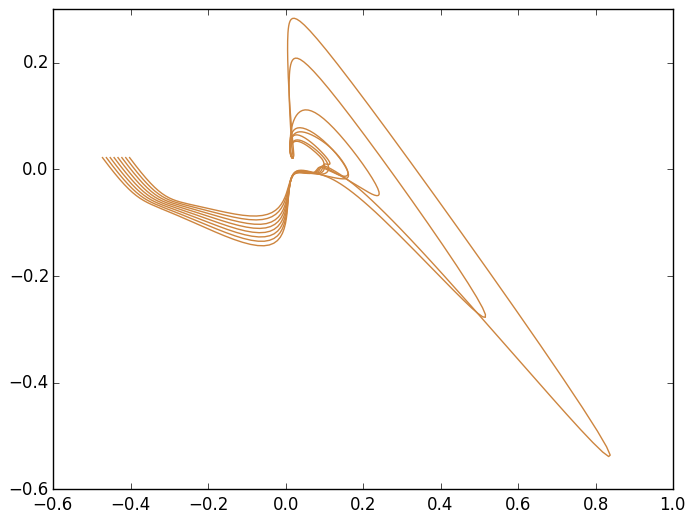

In [35]:
fase_12

 10.755119 seconds (274.93 M allocations: 4.444 GB, 3.17% gc time)


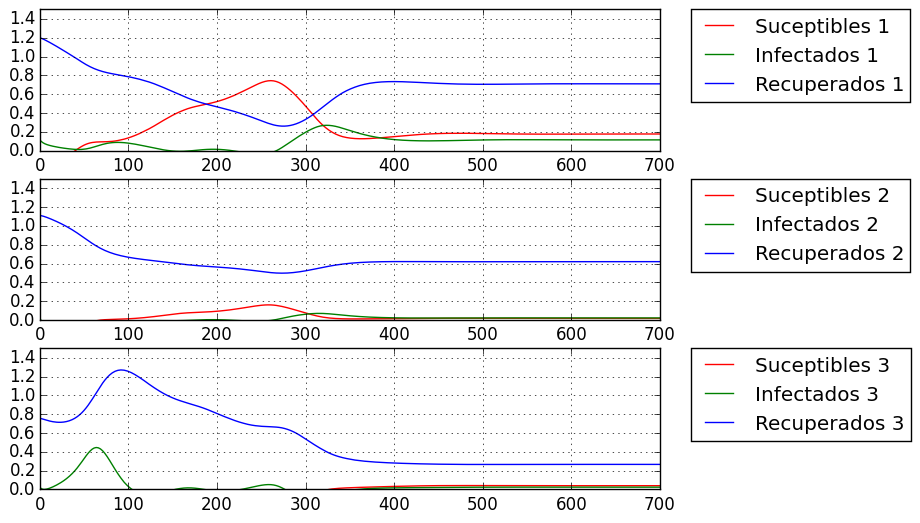

In [27]:
@time t3_atrac,s3_atrac,i3_atrac,r3_atrac = k_3_reincidencia(N1, N2, N3, I_pert_1, I_pert_2, 
I_pert_3, R_pert_1, R_pert_2, R_pert_3,0., 2500., 
    gamma_crit, beta_crit, phi_crit);

gráfica_9 = figure()
for k = 1:3
    subplot(3,1,k)
    plot(t3_atrac, s3_atrac[k], color = "red", label = "Suceptibles $k")
    plot(t3_atrac, i3_atrac[k], color = "green", label = "Infectados $k")
    plot(t3_atrac, r3_atrac[k], color = "blue", label = "Recuperados $k")
    axis([0,700., 0, 1.5])
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    grid()
end

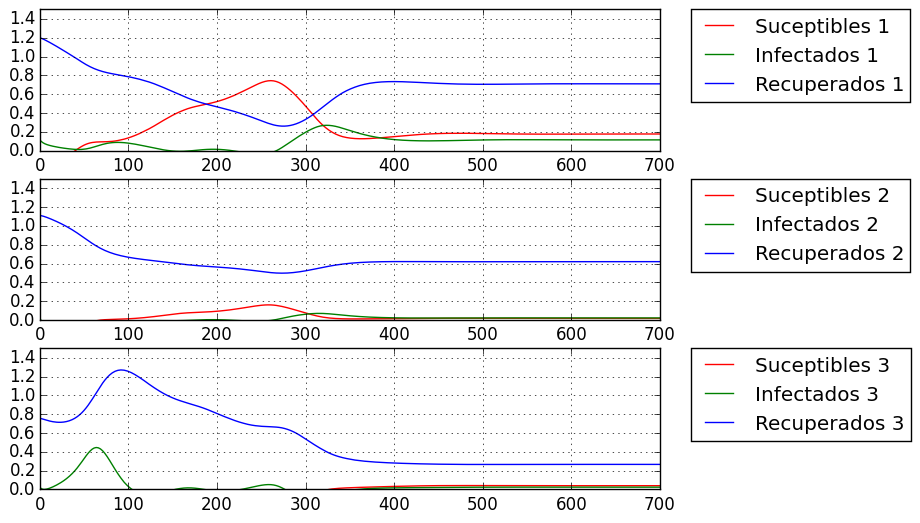

In [34]:
gráfica_9

In [36]:
eps_abs = 1e-39

1.0e-39

### Trabajo posterior

Encontrar los exponentes de Lyapunov como se indica en http://sprott.physics.wisc.edu/chaos/lyapexp.htm . 

Buscar órbitas periódicas, que no pudimos encontrar hasta el momento.

Describir detalladamente los ciclos límite.